# Prepare data and libraries
You can copy (drag/drop) the zip to the colab top directory and then unzip it from there.  However, the copy takes a unusually log time.  It is much faster to first copy the zip file to Google Drive and the copy to colab.  We also import libraries and do sanity checks to make sure the python and libraries are compatible.

Get the data file from GitHub.

❗ If you have not been allocated a GPU by Colab, please download the "tiny" dataset (second wget command).

In [1]:
# If you HAVE been allocated a GPU
!wget https://github.com/efipsom/JGI-Tensorflow/raw/main/data/health_small.zip

--2025-02-08 14:30:15--  https://github.com/efipsom/JGI-Tensorflow/raw/main/data/health_small.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/efipsom/JGI-Tensorflow/main/data/health_small.zip [following]
--2025-02-08 14:30:15--  https://media.githubusercontent.com/media/efipsom/JGI-Tensorflow/main/data/health_small.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530490970 (506M) [application/zip]
Saving to: ‘health_small.zip’

health_small.zip    100%[===================>] 505.92M  73.8MB/s    in 5.1s    

2025-02-08 14:30:32 (100 MB/s) - ‘health_small.zip’ saved [5304909

In [ ]:
# If you HAVE NOT been allocated a GPU
!wget https://github.com/efipsom/JGI-Tensorflow/raw/main/data/health_tiny.zip

In [2]:
# Rename file depending on the file you downloaded in previous step
!unzip -q health_small.zip

Now import libraries and check compatabilities.

In [3]:
import sys

assert sys.version_info >= (3, 7)

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [7]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
print(tf.__version__)

2.18.0


(Optional) Define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Can be very slow without a GPU, check if there's one, or else issue a warning

In [8]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

## Faster GPUs

<p>Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in <code>Runtime &gt; Change runtime type</code> in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.</p>
<p>The free-of-charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.</p>

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is 'Not connected to a GPU', you can change the runtime by going to <code>Runtime &gt; Change runtime type</code> in the menu to enable a GPU accelerator, and then re-execute the code cell.

In [9]:
# If you have purchased google colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb  8 14:33:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              8W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.
You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is 'Not using a high-RAM runtime', then you can enable a high-RAM runtime via <code>Runtime &gt; Change runtime type</code> in the menu. Then select High-RAM in the Runtime shape drop-down. After, re-execute the code cell.

In [10]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [11]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd

In [12]:
print(tf.__version__)

2.18.0


# Custom model
Create a custom CNN model and train on the data.  Evaluate using the validation set to estimate the model's accuracy.

In [13]:
# Images are originally 600x450
# I think image_dataset_from_directory scales???
batch_size = 32
#img_height = 180
#img_width = 180
#img_height = 360
#img_width = 360
img_height = 224
img_width = 224
#img_height = 450
#img_width = 600
#img_height = 400
#img_width = 400
rseed = 123

num_epochs=30

Rename folder in next line if necessary (if you've downloaded the tiny dataset).

In [14]:
data_dir = "./health_small/"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  #label_mode='int',
  crop_to_aspect_ratio=True,
  color_mode="rgb",
  subset="training",
  seed=rseed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

Found 1923 files belonging to 7 classes.
Using 1539 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  #label_mode='int',
  crop_to_aspect_ratio=True,
  color_mode="rgb",
  subset="validation",
  seed=rseed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

Found 1923 files belonging to 7 classes.
Using 384 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


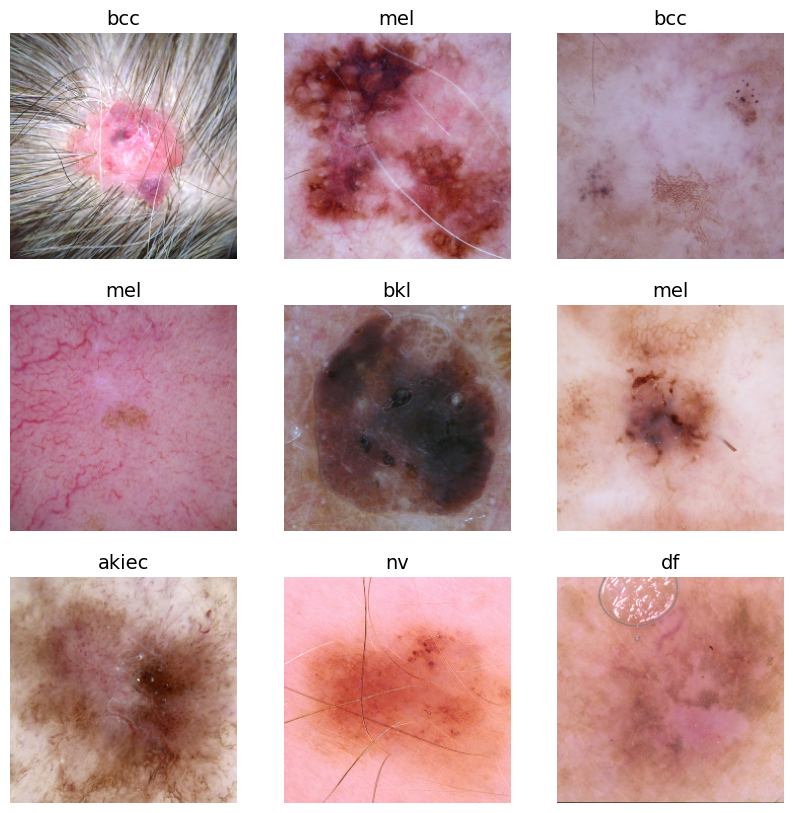

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# Given three Conv2d layers (32,64,128 maps) and dense (128,64), kernel_sizes 5,5,3 as does 5,3,3
# tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2,2), activation="relu"),
# Given five Conv2d layers, kernel_sizes 5,5,3,3 did ok
# Using strides=(2,2) reduces computational burden as each conv_max pool reduces by four
#   have yet to see a downside, get roughly same accuracy
#   the conv2d+stride is learnable whereas max poolinng is fixed (no params)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=[img_height, img_width, 3]),
  tf.keras.layers.Conv2D(32, 7, strides=2, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  # Oddly, bad idea
  #tf.keras.layers.Dense(32, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,006,727 (7.66 MB)

 Trainable params: 2,006,727 (7.66 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit( train_ds, validation_data=val_ds, epochs=num_epochs )

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step - accuracy: 0.1905 - loss: 1.9535 - val_accuracy: 0.1510 - val_loss: 1.9143
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1696 - loss: 1.9101 - val_accuracy: 0.2031 - val_loss: 1.9141
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1877 - loss: 1.9004 - val_accuracy: 0.1771 - val_loss: 1.8865
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1833 - loss: 1.8777 - val_accuracy: 0.2161 - val_loss: 1.8649
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2370 - loss: 1.8251 - val_accuracy: 0.2500 - val_loss: 1.7500
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2364 - loss: 1.7697 - val_accuracy: 0.2370 - val_loss: 1.7000
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2836 - loss: 1.7394 - val_accuracy: 0.2760 - val_loss: 1.6613
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2882 - loss: 1.7234 - val_accuracy: 0.2786 - val_loss: 

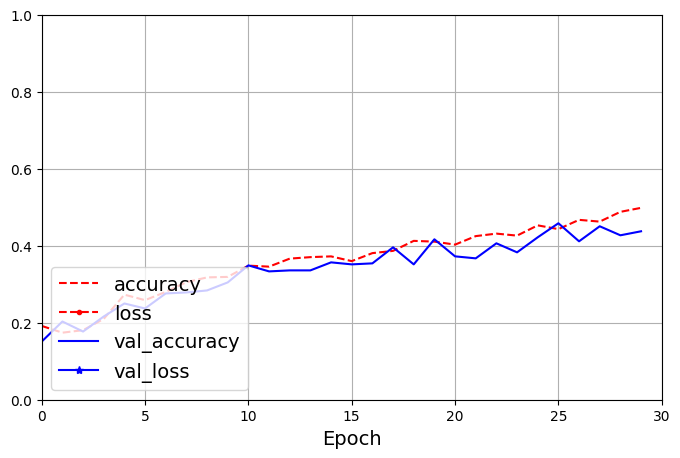

In [22]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

## Discussions:
* What is your observation on accuracy and no. of epochs?
* What change can be made to improve accuracy?

# Residual CNN
Create a well known resnet model and train/evaluate.

In [23]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [24]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[img_height, img_width, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualLayer(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# compiles and provide model summary
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer (ResidualLayer)       │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_1 (ResidualLayer)     │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_2 (ResidualLayer)     │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_3 (ResidualLayer)     │ (None, 28, 28, 128)         │         230,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_4 (ResidualLayer)     │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_5 (ResidualLayer)     │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_6 (ResidualLayer)     │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_7 (ResidualLayer)     │ (None, 14, 14, 256)         │         920,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_8 (ResidualLayer)     │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_9 (ResidualLayer)     │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_10 (ResidualLayer)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_11 (ResidualLayer)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_12 (ResidualLayer)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_13 (ResidualLayer)    │ (None, 7, 7, 512)           │       3,676,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_14 (ResidualLayer)    │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_layer_15 (ResidualLayer)    │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │              

 Total params: 21,305,287 (81.27 MB)

 Trainable params: 21,288,263 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [27]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.8152 - loss: 0.5121 - val_accuracy: 0.4219 - val_loss: 2.3137
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8024 - loss: 0.5143 - val_accuracy: 0.5000 - val_loss: 2.2085
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.8249 - loss: 0.4286 - val_accuracy: 0.4193 - val_loss: 3.3402
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8462 - loss: 0.3967 - val_accuracy: 0.4323 - val_loss: 2.5869
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.8923 - loss: 0.3237 - val_accuracy: 0.4714 - val_loss: 2.5805
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9091 - loss: 0.2968 - val_accuracy: 0.3177 - val_loss: 4.2498
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9084 - loss: 0.2687 - val_accuracy: 0.4115 - val_loss: 3.3500
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9394 - loss: 0.1813 - val_accuracy: 0

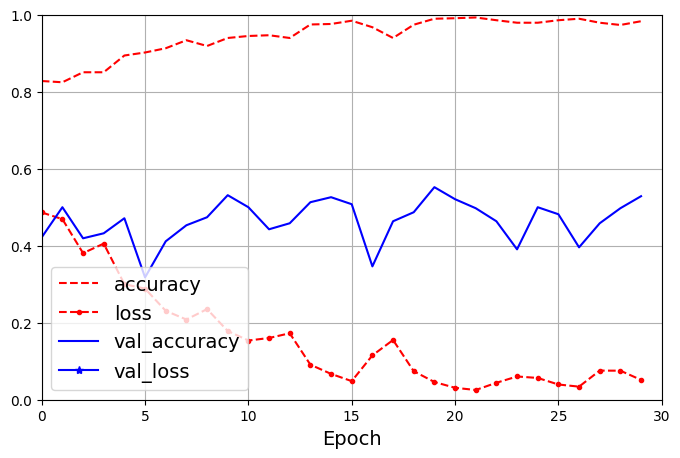

In [28]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

## Disucssions:
* What is your observation on accuracy/loss with no. of epoches?
* Should we increase the number of epochs?

# Transfer Learning
We use existing model architecture and its pre-trained weights.  The base model was trained on the ImageNet dataset that has 1000 classes (the top layer uses a softmax to classify from the one thousand categories).  We only have 7 classes so will only need the model/weights for the representation learning part of the base model and exclude the top layer.  We will than add our top layer for the seven classes.  Then we will then unfreeze all the layers of the base model (i.e. make trainable). Finally, we train new model on our data.

In [29]:
#num_classes=7
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [30]:
# After changing trainnable need to compile
for layer in base_model.layers:
    layer.trainable = True

# compiles and provide model summary ""
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,875,823 (79.63 MB)

 Trainable params: 20,821,295 (79.43 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [31]:
# fits, evaluates, and uses the model to make predictions
num_epochs=20
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 835ms/step - accuracy: 0.4518 - loss: 1.4540 - val_accuracy: 0.1823 - val_loss: 7.4011
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - accuracy: 0.7350 - loss: 0.7946 - val_accuracy: 0.3880 - val_loss: 3.3050
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - accuracy: 0.8571 - loss: 0.4454 - val_accuracy: 0.5182 - val_loss: 3.1083
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 436ms/step - accuracy: 0.8992 - loss: 0.3088 - val_accuracy: 0.4635 - val_loss: 4.2110
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.9058 - loss: 0.2515 - val_accuracy: 0.6042 - val_loss: 2.2088
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 443ms/step - accuracy: 0.9482 - loss: 0.1623 - val_accuracy: 0.7135 - val_loss: 1.3010
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.9644 - loss: 0.1083 - val_accuracy: 0.5729 - val_loss: 2.4776
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.9697 - loss: 0.1024 - val_acc

## Discussions:
* How do you think transfer learning helped with this task?

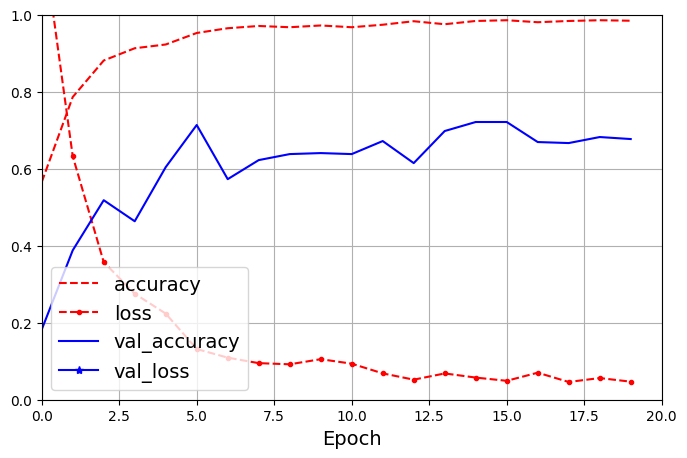

In [39]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

# Save the model

## Save the model to use later for predicting the type of mole/skin images.

model.save("skin_cancer_xception_model".h5)


## Reading and using saved model
This is an example of reading back in just the model and using.  You will still need to import libraries, etc.

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing import image_dataset_from_directory

#=====================================================#
# Restore the previously saved model
#=====================================================#
# If the model was saved in the SavedModel format
model = tf.keras.models.load_model("skin_cancer_xception_model.h5")

# If the model was saved as an .h5 file
# model = tf.keras.models.load_model("skin_cancer_xception_model.h5")

# (Optional) Show the contents of the saved model directory
# for path in sorted(Path("skin_cancer_xception_model").glob("**/*")):
#     print(path)

#=====================================================#
# Load Training and Validation Data
#=====================================================#
# ... (your previous code) ...

#=====================================================#
# Load Training and Validation Data
#=====================================================#
# Replace with the actual paths to your training and validation data
train_ds = image_dataset_from_directory(
    "./health_small/",  # Updated with actual path to training data
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.20,
    #label_mode='int',
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    subset="training",
    seed=rseed,
    shuffle = True
)

val_ds = image_dataset_from_directory(
    "./health_small/",  # Updated with actual path to validation data
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.20,
    #label_mode='int',
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    subset="validation",
    seed=rseed,
    shuffle = True
)

#=====================================================#
# Continue training the model
#=====================================================#
num_epochs = 30
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

# ... (rest of your code) ...

val_ds = image_dataset_from_directory(
    "path_to_validation_data",  # <-- Update with actual path
    image_size=(224, 224),
    batch_size=32
)

#=====================================================#
# Continue training the model
#=====================================================#
num_epochs = 30
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

#=====================================================#
# Evaluate the model (Optional)
#=====================================================#
# model.evaluate(test_ds)


Found 1923 files belonging to 7 classes.
Using 1539 files for training.
Found 1923 files belonging to 7 classes.
Using 384 files for validation.
Epoch 1/30


NotImplementedError: numpy() is only available when eager execution is enabled.

In [49]:
# ... (your previous code) ...

# Save the model in HDF5 format
model.save("skin_cancer_xception_model.h5")

# ... (later, when loading the model) ...

# Load the model from the HDF5 file
model = tf.keras.models.load_model("skin_cancer_xception_model.h5")

In [9]:

#=====================================================#
# Restore the previously saved model
#=====================================================#
# If the model was saved in the SavedModel format
model = tf.keras.models.load_model("skin_cancer_xception_model.h5")

# If the model was saved as an .h5 file
# model = tf.keras.models.load_model("skin_cancer_xception_model.h5")

# (Optional) Show the contents of the saved model directory
# for path in sorted(Path("skin_cancer_xception_model").glob("**/*")):
#     print(path)

#=====================================================#
# Load Training and Validation Data
#=====================================================#
# ... (your previous code) ...

#=====================================================#
# Load Training and Validation Data
#=====================================================#
# Replace with the actual paths to your training and validation data
train_ds = image_dataset_from_directory(
    "./health_small/",  # Updated with actual path to training data
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.20,
    #label_mode='int',
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    subset="training",
    seed=rseed,
    shuffle = True
)

val_ds = image_dataset_from_directory(
    "./health_small/",  # Updated with actual path to validation data
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.20,
    #label_mode='int',
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    subset="validation",
    seed=rseed,
    shuffle = True
)

#=====================================================#
# Continue training the model
#=====================================================#
num_epochs = 30

# Enable eager execution before calling fit
tf.config.run_functions_eagerly(True)  # This line added to force eager execution
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

# (Optional) - Disable eager execution after training
# tf.config.run_functions_eagerly(False)

# ... (rest of your code) ...

val_ds = image_dataset_from_directory(
    "path_to_validation_data",  # <-- Update with actual path
    image_size=(224, 224),
    batch_size=32
)

#=====================================================#
# Continue training the model
#=====================================================#
num_epochs = 30

# Enable eager execution before calling fit
tf.config.run_functions_eagerly(True)  # This line added to force eager execution
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

# (Optional) - Disable eager execution after training
# tf.config.run_functions_eagerly(False)

#=====================================================#
# Evaluate the model (Optional)
#=====================================================#
# model.evaluate(test_ds)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'skin_cancer_xception_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [1]:
def show_history(history, num_epochs):
    pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")  # extra code
    #save_fig("keras_learning_curves_plot")  # extra code
    plt.show()

In [3]:
show_history(history, num_epochs)

NameError: name 'history' is not defined

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd  # Import pandas for DataFrame


def show_history(history, num_epochs):
    pd.DataFrame(history.history).plot(
        figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")  # extra code
    # save_fig("keras_learning_curves_plot")  # extra code
    plt.show()


# ... (your previous code that defines and trains the model, setting 'history') ...

# Example training code (make sure this or similar is executed before calling show_history)
model = tf.keras.models.load_model("skin_cancer_xception_model.h5")
# Assuming model is loaded correctly
# ... Load your training and validation data ...

# Make sure these lines are uncommented and executed to train and get the history:
num_epochs = 30
# Assuming train_ds and val_ds are defined and loaded correctly
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)  # This line assigns a value to 'history'

# Now call show_history after training:
show_history(history, num_epochs)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'skin_cancer_xception_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd  # Import pandas for DataFrame


def show_history(history, num_epochs):
    pd.DataFrame(history.history).plot(
        figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")  # extra code
    # save_fig("keras_learning_curves_plot")  # extra code
    plt.show()


# ... (your previous code that defines and trains the model, setting 'history') ...

# Example training code (make sure this or similar is executed before calling show_history)
# model = tf.keras.models.load_model("skin_cancer_xception_model.h5")
# ... Load your training and validation data ...
# num_epochs = 30
# history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

# Now call show_history after training:
show_history(history, num_epochs)

NameError: name 'history' is not defined

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd  # Import pandas for DataFrame


def show_history(history, num_epochs):
    pd.DataFrame(history.history).plot(
        figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")  # extra code
    # save_fig("keras_learning_curves_plot")  # extra code
    plt.show()


# ... (your previous code that defines and trains the model, setting 'history') ...

# Example training code (make sure this or similar is executed before calling show_history)
model = tf.keras.models.load_model("skin_cancer_xception_model.h5")  # Assuming model is loaded correctly
# ... Load your training and validation data ...

# Make sure these lines are uncommented and executed to train and get the history:
num_epochs = 30
# Assuming train_ds and val_ds are defined and loaded correctly
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

# Now call show_history after training:
show_history(history, num_epochs)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'skin_cancer_xception_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)